# Convolutional Neural Networks

**Time**
- Teaching: 1.5 hours
- Challenges: 30 minutes

**Questions**
- "What is CIFAR10 and how does the modeling process and challenges differ from MNIST?"
- "How do convolutional neural networks differ from vanilla neural networks?"
- "How do we write python code to develop convolutional neural networks?"
- "What options do we have to train large models if my personal machine can't handle it?"


**Learning Objectives**
- "Understand the process of data preprocessing for deep learning."
- "Build python functions that help us process and visualize our data."
- "Take a peek at the machinery underlying convolutional neural networks."
- "Understand the hardware constrains in deep learning."

* * * * *

## Import packages

For this notebook, instead of importing only specific functions, we will also import modules that contain functions.

**Old way:**

`from keras.layers import Dense`

`model.add(Dense(...))`

**New way:**

`from keras import layers`

`model.add(layers.Dense(...))`

But why change it up? I had trouble myself in the past understanding the way modules work, so code would break due simply to the way imports were done. Let's avoid that by getting comfortable with python modules!

In [ ]:
from keras import layers
from keras import models
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

### CIFAR10

So we get sidetracked at work and we want to instead build a classifier for animals and vehicles!

We shop around and find an interesting image dataset called [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html).

This dataset consists of:
- 60,000 total images
- 10 classes (6,000 images per class)

Example images of each class are shown below:

![CIFAR10 classes](https://maet3608.github.io/nuts-ml/_images/cifar10.png)

### Loading the dataset

In [ ]:
def load_cifar10(subset = True):
    """
    Loads a training, validation, and test set of CIFAR10 images.
    
    When subset=TRUE:
    Returns only a subset of the mnist dataset.
    Especially important to use if you are on datahub and only have 1-2GB of memory.
    """
    if subset:
        N_TRAIN = 8000
        N_VALIDATION = 2000
        N_TEST = 2000
    else:
        N_TRAIN = 40000
        N_VALIDATION = 10000
        N_TEST = 10000
    
    (x_train_and_val, y_train_and_val), (x_test, y_test) = cifar10.load_data()
    
    x_train = x_train_and_val[:N_TRAIN,:,:]
    y_train = y_train_and_val[:N_TRAIN]
    
    x_val = x_train_and_val[N_TRAIN: N_TRAIN + N_VALIDATION,:,:]
    y_val = y_train_and_val[N_TRAIN: N_TRAIN + N_VALIDATION]
    
    x_test = x_test[:N_TEST]
    y_test = y_test[:N_TEST]
    
    return x_train, y_train, x_val, y_val, x_test, y_test
    

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = load_cifar10()

### Input Data Due Dillegence

We will borrow some of our previous functions in order to get a feel for CIFAR10.

In [ ]:
def data_summary(data):
    """
    Takes a list of our data partitions and returns the shape.
    """
    
    for i, data_partition in enumerate(data):
        if i == 0:
            print("Training Data")
        elif i == 2:
            print()
            print("Validation Data")
        elif i == 4:
            print()
            print("Testing Data")

        print(f"Shape: {data_partition.shape}")

In [ ]:
data_summary([x_train, y_train, x_val, y_val, x_test, y_test])

In [ ]:
one_image = x_train[0]
one_image.shape

In [ ]:
plt.imshow(one_image);

Can you tell what the class of the image above is!?

Let's show more images with their correct class from the CIFAR10 dataset!

In [ ]:
def plot_images(x, y, random=False):
    """
    Plots 25 images from x data with titles set as y.
    Set random=True if you want random images rather than the first 25.
    """
    
    if random:
        indices = np.random.choice(range(y.shape[0]), 25, replace=False)
    
    else:
        indices = np.array(range(25))
    
    fig, axes = plt.subplots(5,5, figsize = (15,15))
    axes = axes.ravel()
    
    for ax, index in zip(axes, indices):
        ax.imshow(x[index])
        ax.set_title(f"Class: {y[index][0]}", size=15)
    
    plt.tight_layout()
    
    return plt.show()

In [ ]:
plot_images(x_train, y_train)

Oh no, the class labels are just digits!

## Challenge 1: Translate Classes

Create a function `translate_class()` that uses the correct class name for the target classes (truck, horse, etc..).
- Use the [keras CIFAR10 documentation](https://keras.io/api/datasets/cifar10/) as a guide to know how the classes are labeled.
- The function should take a class index [0-9]
- The function should return the correct corresponding CIFAR10 class category.

In [ ]:
def translate_class(class_integer):
    # Your code here
    return None

## Challenge 2: Plotting Image Classes

Create a new function `my_imageplotter()` that reuses code from our `plot_images()` function and incorporates the `translate_class()` function to give us the correct class titles in our images.

In [ ]:
def my_imageplotter(x, y, random=False):
    """
    Plots 25 images from x data with titles set as y.
    Set random=True if you want random images rather than the first 25.
    """
    
    # Add code to this function that translates the image class!
    
    if random:
        indices = np.random.choice(range(y.shape[0]), 25, replace=False)
    
    else:
        indices = np.array(range(25))
    
    fig, axes = plt.subplots(5,5, figsize = (15,15))
    axes = axes.ravel()
    
    for ax, index in zip(axes, indices):
        ax.imshow(x[index])
        ax.set_title(f"Class: {y[index][0]}", size=15)
    
    plt.tight_layout()
    
    return plt.show()

Test your function below!

In [ ]:
my_imageplotter(x_train, y_train)

Let's make sure we have balanced class distributions.

In [ ]:
def plot_target_distributions(targets, titles):
    """
    Returns the distribution of target classes.
    """
    
    fig, axes = plt.subplots(3,1, figsize = (10,10))
    
    for ax, target, title in zip(axes, targets, titles):
        ax.hist(target) 
        ax.set_title(f"{title} Class Distribution")
    
    return plt.show()

In [ ]:
plot_target_distributions([y_train, y_val, y_test], ["Train", "Validation", "Test"])

Before writing code to build a convolutional neural network, let's quickly review what the significance a convolutional neural network is, the convolutional layer.

#### Convolutional layers
As reviewed in our slides, convolutional layers contain *filters* that we *stride* along our image to find matching patterns, producing a *response map*. 

![title](https://qph.fs.quoracdn.net/main-qimg-6428cf505ac1e9e1cf462e1ec8fe9a68)
- The green boxes represent the pixels in our input image.
- The yellow boxes represent the *filter*.
- The movement of the filter represents the *stride*.
- The red boxes represent our *response map*.

### Data Transformation

Notice that the input dimensions of our images in convolutional neural networks do not to be flattened to one dimension. Instead, we can have multidimensional input data which is perfect for our 3-dimensional pixel data (row pixel, column pixel, channel).

Let's scale our pixel values between [0,1] and transform the targets to one hot encoded categorical columns.

In [ ]:
def three_dim_transform(x_data, y_data):
    """
    Transforms image data:
        - Scales pixel values between [0,1]
    Transforms target data (ydata):
        - Formats targets as one hot encoded columns
    """
    
    x = {}
    for name, partition in zip(["x_train", "x_val", "x_test"],x_data):
        scaled = partition.astype('float32') / 255
        x[name] = scaled
    
    y = {}
    for name, partition in zip(["y_train", "y_val", "y_test"],y_data):
        y[name] = to_categorical(partition)
    
    return x['x_train'], y['y_train'], x['x_val'], y['y_val'], x['x_test'], y['y_test']
    

In [ ]:
x_train_trans, y_train_trans, x_val_trans, y_val_trans, x_test_trans, y_test_trans = three_dim_transform([x_train, x_val, x_test],
                                                                                                    [y_train, y_val, y_test])

### Convolutional Neural Network Model Syntax

Let's jump right in and build a convolutional neural network!

We initialize a convolutional neural network the same way we did a vanilla neural network.

In [ ]:
convnet = models.Sequential()

We now add our first convolutional layer. 

*Note: I use the argument names here to clarify what parameters we are passing into our neural network including default values.*

In [ ]:
convnet.add(layers.Conv2D(filters = 32,
                          kernel_size = (3, 3),
                          strides = (1,1),
                          activation= "relu",
                          input_shape=(32, 32, 3)))

We define our first convolutional layer using:
`.add(layers.Conv2D(...))`
- This adds a convolutional layer to our model object.

`filters = 32`
- Initializes 32 filters total.
- Each filter slides along the entire image.
- Each filter produce a response map.

`kernel_size = (3, 3)`
- Specifies the "kernel" size of the filters.
- (3 x 3) : (height x width)
    
`strides = (1,1)`
- The filter strides by one unit in both the horizontal and vertical dimension.
- (1 x 1) or (height stride x width stride)

`activation= "relu"`
- Uses the relu (Rectified Linear Unit) activation function on the response map values.
- This simply causes any negative values to be 0, and other values to stay the same.

`input_shape=(32, 32, 3)`
- Specifies the shape of our input data
- 32 pixels wide
- 32 pixels high
- 3 channels deep (Red, Green, Blue)

#### Max Pooling layers
After a convolutional layer, we can downsample a *reponse map* using a maxpooling layer. This simply takes the maximum value for a given kernel-size sliding along our response map, much like a filter. 

Maxpooling has a dual benefit. Not only does it effectively reduce the amount of data we must process, but it also improves our focus on finding **good** matches from our filter, making our model less specific about the location where it was found (location invariance).

![title](https://nico-curti.github.io/NumPyNet/NumPyNet/images/maxpool.gif)
- The blue boxes represent our *response map*.
- The purple box represent our kernel size (2 x 2).
- The yellow box is the output of our maxpooling operation.

In [ ]:
convnet.add(layers.MaxPooling2D(pool_size=(2, 2),
                               strides = None))

`.add(layers.MaxPooling2D(...))`
- Adds a maxpooling layer.

`pool_size=(2, 2)`
- Defines the "kernel" size of our maxpooling operation.
- Will return a single value from this entire window

`strides = None`
- None makes it so there is no overlap during striding, just continue to inputs not in the previous window.

#### Dense layers
Until this point, the convolutional and maxpooling layers have been performing feature extraction.

In order to classify our images we return to our good old dense layer, the same we used in our vanilla neural networks. 

Before we can use our dense layer, we first flatten the data passed through the convolutional and maxpooling layers (which are high dimensional) into a single dimension.

We then use a dense layer that is able to *look* at the all of the features extracted from the convolutional operations, and optimize its weights to correctly associate these features with the correct class.

Finally we have our output layer, which contains the same number of neurons as classes we are predicting. We use a softmax activation function, giving us the probability for each class in our prediction.

In [ ]:
convnet.add(layers.Flatten())
convnet.add(layers.Dense(64, activation= "relu"))
convnet.add(layers.Dense(10, activation= "softmax"))

#### Compiling
We now compile our model as we have done previously. Using:
1. rmsprop optimizer to update weights smoothly
2. categorical crossentropy loss function
3. track the accuracy metric

In [ ]:
convnet.compile(optimizer= "rmsprop",
               loss= "categorical_crossentropy", 
               metrics= ["accuracy"])

We now use the fit method to train our model for 20 epochs.

In [ ]:
convnet_history = convnet.fit(x_train_trans,
                             y_train_trans,
                             epochs=20,
                             batch_size = 64,
                             validation_data=(x_val_trans, y_val_trans))

Let's plot the training and validation accuracy through each epoch of our neural network

In [ ]:
def plot_epoch_accuracy(history_dict):
    """
    Plots the training and validation accuracy of a neural network.
    """
    
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, color = 'navy', alpha = 0.8, label='Training Accuracy')
    plt.plot(epochs, val_acc, color = 'green', label='Validation Accuracy')
    plt.title('Training and validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    return plt.show()

In [ ]:
plot_epoch_accuracy(convnet_history.history)

We can see that our Convolutional Neural Network is failing to generalize. While our training accuracy keeps increasing throughout our 20 epochs, our validation accuracy stalls at ~50%.

Let's plot these incorrect predictions and see if they make sense to our own image recognition system, our brain!

In [ ]:
def plot_wrong_predictions(model, x_test, y_test):
    """
    Plots 25 incorrectly predicted images.
    """
    
    # Format predictions and targets
    predictions = model.predict(x_test)
    predicted = np.argmax(predictions, axis = 1)
    target = np.argmax(y_test, axis = 1)
    
    # Set up subplots
    fig, axes = plt.subplots(5,5, figsize = (25,25))
    axes = axes.ravel()
    
    for ax, index in zip(axes, range(25)):
        ax.imshow(x_test[index], cmap=plt.cm.binary, interpolation='nearest')
        prediction_title = translate_class(predicted[index])
        target_title = translate_class(target[index])
        
        # Color title based on if prediction is correct
        if predicted[index] == target[index]:
            color = "green"
        else:
            color = "red"
            
        ax.set_title(f"Predicted {prediction_title}, Actual is {target_title}", color = color)
    
    return plt.show()

In [ ]:
plot_wrong_predictions(convnet,
                      x_test_trans,
                      y_test_trans)

Do you see any patterns that this convolutional neural network is able to pick up?

### Troubleshooting

Perhaps our model is not able to extract enough features for this complex problem. To address this possibility let's build a model with:
1. More convolutional layers
2. More neurons in the dense layer

## Challenge 3: Create a Convolutional Neural Network

1. Initialize a Convolutional Neural Network called `my_convnet` with the following architecture:
    * Conv2D layer with 32 3x3 filters and relu activation function
    * Maxpooling layer 2x2
    * Conv2D layer with 64 3x3 filters and relu activation function
    * Maxpooling layer 2x2
    * Conv2D layer with 128 3x3 filters and relu activation function
    * Maxpooling layer wtih a pool size of 2x2
    * A flattening layer
    * A dense layer with 512 neurons  and relu activation function
    * An output layer with the number of classes and softmax activation function

2. Compile with the model with:
    * rmsprop optimizer
    * categorical crossentropy loss
    * accuracy metric

3. Train the network for 20 epochs.

4. Plot the training and validation accuracy through each epoch


Does expanding the architecture have a significant impact on the validation accuracy of the model?

### Generalization with Image Augmentation

In our vanilla neural network, we prevented overfitting to the training data by using a dropout layer.

We could do the same for our convolutional neural network, but instead of using dropout, let's use image augmentation. We will feed altered images with a random amount of rotation, shifting, distorted, and flipped! This will make our neural network generalize to different image orientations.

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
def plot_image_augmentation(augment_gen, image, n = 4):
    """
    Takes an image data generator and an images.
    Returns n plots of augmented images.
    """
    image = image.reshape((1,) + image.shape)
    
    i = 0
    
    for batch in augment_gen.flow(image, batch_size = 1):
        plt.figure(i)
        plt.imshow(batch[0])
        
        i += 1
        if i % n == 0:
            break

        plt.show()
        

In [ ]:
plot_image_augmentation(datagen, x_test_trans[12])

Let's reuse the architecture from our first convolutional neural network, then fit it using these augmented images.

*Warning* - This will take a while!

In [ ]:
augmented_image_model = models.Sequential()

augmented_image_model.add(layers.Conv2D(32, (3,3), activation= "relu", input_shape = (32, 32, 3)))
augmented_image_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
augmented_image_model.add(layers.Conv2D(32, (3,3), activation= "relu"))

augmented_image_model.add(layers.Flatten())
augmented_image_model.add(layers.Dense(64, activation= "relu"))
augmented_image_model.add(layers.Dense(10, activation= "softmax"))

augmented_image_model.compile(optimizer= "rmsprop",
                   loss= "categorical_crossentropy",
                   metrics= ["accuracy"])

In [ ]:
augmented_image_model_history = augmented_image_model.fit(
    datagen.flow(
        x_train_trans,
        y_train_trans,
        batch_size=32),
    validation_data=datagen.flow(
        x_val_trans,
        y_val_trans,
        batch_size=32),
    steps_per_epoch = 200,
    epochs=20)


In [ ]:
plot_epoch_accuracy(augmented_image_model_history.history)

Even after training a convolutional neural network with image augmentation for 100 epochs, we still don't cross the 60% validation accuracy threshold. 

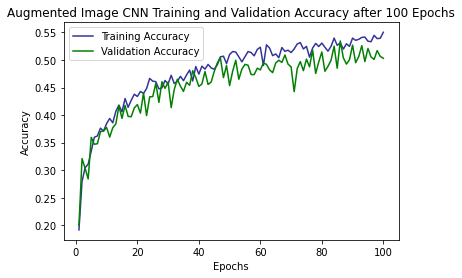

### Results

Let's compare the accuracy of our three models.

In [ ]:
def get_model_accuracy(model, x_test, y_test):
    """
    Takes a model and a test set of data.
    Returns the accuracy.
    """
    
    score = model.evaluate(x_test, y_test, verbose=0)
    
    accuracy = round(score[1]*100, 1)
    
    return accuracy

In [ ]:
for i, mod in enumerate([convnet, my_convnet, augmented_image_model]):
    acc = get_model_accuracy(mod, x_test_trans, y_test_trans)
    print(f"Model {i+1} has an accuracy of {acc}%")

Do you feel satisfied with these results?

The convolutional neural networks we built are relatively small compared to those used in applications such as google photos.

Let's compare the architecture from the models we built with a popular convolutional neural network called [VGG16](https://arxiv.org/pdf/1409.1556.pdf). 

### First Convolutional Neural Network

In [ ]:
convnet.summary()

### Second Convolutional Neural Network

In [ ]:
my_convnet.summary()

### VGG16

![title](https://alexisbcook.github.io/assets/vgg16_keras.png)

## Hardware for Deep-Learning

We are highly restricted in our ability to train larger models due to our hardware. While there are many aspects about hardware that are critical to deep learning, we will focus on one major concept, the Processing Unit.

All computers have a Central Processing Unit (CPU) that performs all of the operations your computer needs to do, including running all this python code!

For deep-learning, CPUs are not very efficient at running the massive number operations required to train deep neural networks. That's where the Graphical Proccessing Unit (GPU) comes into the picture. 

GPUs, originally designed to render complex graphics have been repurposed for training neural networks! This key innovation came in 2007 when NVIDIA launched [CUDA](https://developer.nvidia.com/about-cuda), a programming interface for GPUs which allows highly parallelizable computations. Since many neural networks operations are parallelizable, this has become the go-to-way to train large neural network models.

*Loosely based on: (Chollet 2018) Deep Learning with Python*

The code below allows you to see the available hardware (CPUs, GPUs) that can be used in tensorflow/keras.

In [ ]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

### Final words

So are we doomed? Can only the tech giants create deep neural networks?

Well.. sorta, but we do have alternatives, we just need to be creative! Here are some options to train your own deep neural networks that may aren't possible on your own machine:
1. Use other services

    - Google Colab
    - Amazon Web Services (AWS) allows you to use their hardware in "EC2 instances" to train your models offerring a [dizzying number of options](https://aws.amazon.com/ec2/instance-types/). Note that this can be expensive and is billed by time!
    
2. Transfer learning
    - Why build your model from the ground up?
    - Transfer learning uses an existing model with all it's tuned weights, and retrains just the final portion of the model to a new task.